# Visualising RDMs

Here we are, visualising RDMs.

In [1]:
import matplotlib.pyplot as plt
from pyrsa import vis
from pyrsa import rdm
import numpy as np
import os
import inspect
import scipy.io

In [2]:
DEMO_DIR = os.path.dirname(inspect.getfile(inspect.currentframe()))
NEURON_DIR = os.path.join(DEMO_DIR, "92imageData")


def neuron_2008_images():
    """ Load Krigeskorte et al. (2008, Neuron) images as Icon instances."""
    mat_path = os.path.join(NEURON_DIR, "Kriegeskorte_Neuron2008_supplementalData.mat")
    mat = scipy.io.loadmat(mat_path)
    return [
        vis.Icon(image=this_image) for this_image in mat["stimuli_92objs"][0]["image"]
    ]


def neuron_2008_rdms_fmri():
    """ Load Kriegeskorte et al. (2008, Neuron) fMRI RDMs as RDMs instance."""
    mat_path = os.path.join(NEURON_DIR, "92_brainRDMs.mat")
    mat = scipy.io.loadmat(mat_path)
    images = neuron_2008_images()
    # insert leading dim to conform with pyrsa nrdm x ncon x ncon convention
    return rdm.concat(
        [
            rdm.RDMs(
                dissimilarities=this_rdm["RDM"][None, :, :],
                dissimilarity_measure="pearson",
                rdm_descriptors=dict(
                    zip(["ROI", "subject", "session"], this_rdm["name"][0].split(" | "))
                ),
                pattern_descriptors=dict(image=images)
            )
            for this_rdm in mat["RDMs"].flatten()
        ]
    )


In [3]:
images = neuron_2008_images()
rdms = neuron_2008_rdms_fmri()

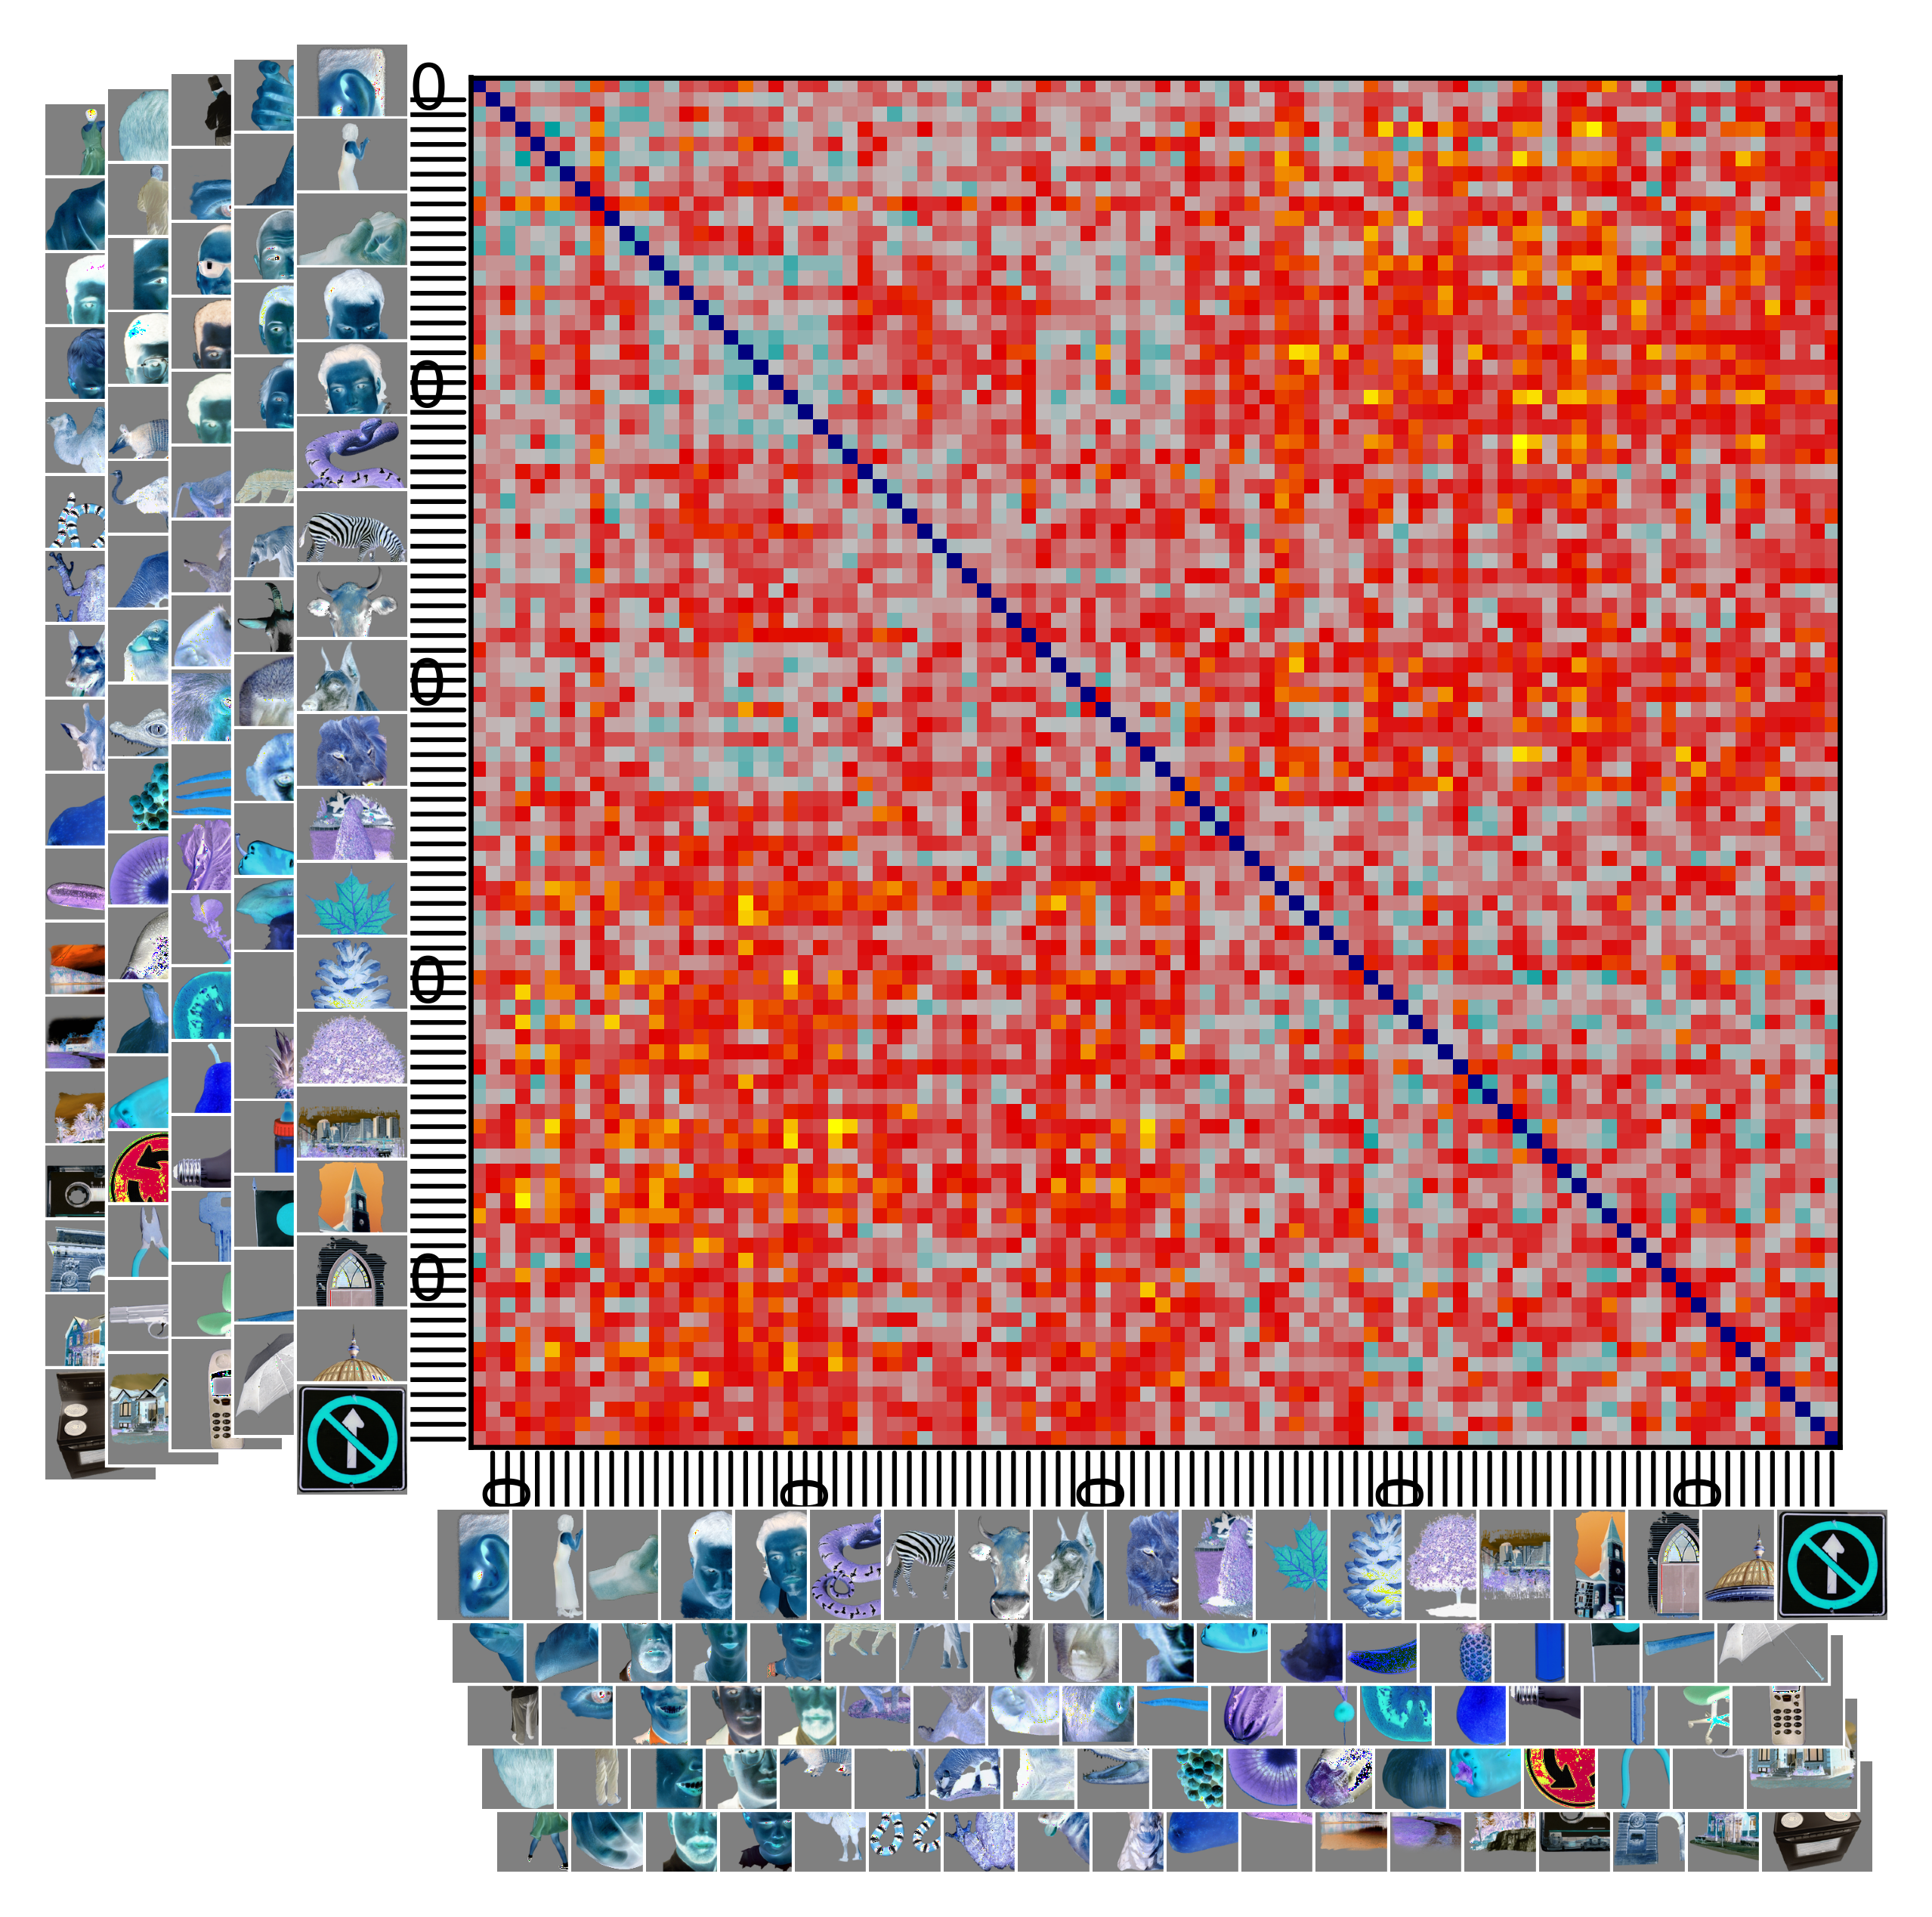

In [9]:
vis.show_rdm(rdms[0],
             pattern_descriptor='image',
             num_pattern_groups=5,
             size=.1,offset=10)

In [55]:
# let's work out transforms for the axis to display pixels
# we can then set the zoom setting above more intelligently
# (following https://matplotlib.org/tutorials/advanced/transforms_tutorial.html)
# NB note about adding an on_draw event handler to make this zoom change dynm

# display coordinate for the corners of the axis
print(col_ax.transAxes.transform((0,0)))
print(col_ax.transAxes.transform((1,1)))
# so the extent would be
print(np.diff(col_ax.transAxes.transform(np.array([[0.,0.],[1,1]])), axis=0))
# so let's just check that
print(np.diff(rdm_ax.transAxes.transform(np.array([[0.,0.],[1,1]])), axis=0))
# and
print(np.diff(row_ax.transAxes.transform(np.array([[0.,0.],[1,1]])), axis=0))

[ 72.         514.04651163]
[500.65116279 648.        ]
[[428.65116279 133.95348837]]
[[428.65116279 428.65116279]]
[[133.95348837 428.65116279]]


In [77]:
# ok, so what are the image dimensions?
print(images[0].final_image.width)
# so sticking with col_ax, we know we have how many images to stack?
print(np.ceil(rdms[0].n_cond / num_pattern_groups))
# and col_ax is how wide in pixels?
print(np.diff(col_ax.transAxes.transform(np.array([[0.,0.],[1,1]])), axis=0)[0,0])
# and that leaves how many pixels per image?
print(np.diff(col_ax.transAxes.transform(np.array([[0.,0.],[1,1]])), axis=0)[0,0] /
     np.ceil(rdms[0].n_cond / num_pattern_groups))
# so then the scale factor (ie, the zoom) is
print((np.diff(col_ax.transAxes.transform(np.array([[0.,0.],[1,1]])), axis=0)[0,0] /
     np.ceil(rdms[0].n_cond / num_pattern_groups)) / images[0].final_image.width)
# let's test that
# IT WORKS

175
16.0
428.65116279069775
26.79069767441861
0.15308970099667776
